## ShuffleNet

In [28]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
!pip install seaborn timm tqdm wandb matplotlib 

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
#@title import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import time
import numpy as np
from tqdm.notebook import tqdm
import wandb
import matplotlib.pyplot as plt
from collections import OrderedDict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [23]:
#@title model architecture
class ChannelShuffle(nn.Module):
    """Channel shuffle operation"""
    def __init__(self, groups):
        super(ChannelShuffle, self).__init__()
        self.groups = groups

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        channels_per_group = channels // self.groups
        
        # Reshape and transpose for shuffle
        x = x.view(batch_size, self.groups, channels_per_group, height, width)
        x = x.transpose(1, 2).contiguous()
        x = x.view(batch_size, channels, height, width)
        return x

# SỬA LỖI: Thay thế class ShuffleBlock cũ bằng class đã sửa lỗi này.
class ShuffleBlock(nn.Module):
    """ShuffleNet basic block (Robust version)"""
    def __init__(self, in_channels, out_channels, groups, stride=1):
        super(ShuffleBlock, self).__init__()
        self.stride = stride
        self.groups = groups
        
        # --- START ROBUST FIX ---
        # Logic tính toán mid_channels để đảm bảo luôn chia hết cho groups
        bottleneck_channels = out_channels // 4
        
        # Điều chỉnh để mid_channels là bội số gần nhất của groups
        # Điều này tránh lỗi chia hết cho cả conv1 và conv3
        g_mid_channels = (bottleneck_channels + groups - 1) // groups * groups
        if g_mid_channels == 0:
            g_mid_channels = groups # Xử lý trường hợp số kênh quá nhỏ
        # --- END ROBUST FIX ---

        # First 1x1 grouped convolution
        self.conv1 = nn.Conv2d(in_channels, g_mid_channels, kernel_size=1, 
                               groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(g_mid_channels)
        
        self.shuffle = ChannelShuffle(groups)
        
        # 3x3 depthwise convolution
        self.conv2 = nn.Conv2d(g_mid_channels, g_mid_channels, kernel_size=3,
                               stride=stride, padding=1, groups=g_mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(g_mid_channels)
        
        # Second 1x1 grouped convolution
        self.conv3 = nn.Conv2d(g_mid_channels, out_channels, kernel_size=1,
                               groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
            
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        shortcut_input = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.shuffle(out)
        out = self.bn2(self.conv2(out)) # ReLU is applied after merging
        out = self.bn3(self.conv3(out))
        
        if self.stride == 2:
            shortcut = self.shortcut(shortcut_input)
            out = self.relu(torch.cat([shortcut, out], dim=1))
        else:
            shortcut = shortcut_input
            out = self.relu(out + shortcut)
            
        return out

print("✅ ShuffleBlock đã được sửa lỗi dứt điểm!")

class ShuffleNet(nn.Module):
    """ShuffleNet for CIFAR-10"""
    def __init__(self, groups=3, num_classes=10):
        super(ShuffleNet, self).__init__()
        self.groups = groups
        
        # Stage configurations based on groups
        if groups == 1:
            out_channels = [24, 144, 288, 576]
        elif groups == 2:
            out_channels = [24, 200, 400, 800]
        elif groups == 3:
            out_channels = [24, 240, 480, 960]
        elif groups == 4:
            out_channels = [24, 272, 544, 1088]
        elif groups == 8:
            out_channels = [24, 384, 768, 1536]
        else:
            raise ValueError("Groups not supported")
        
        # First convolution (modified for CIFAR-10's 32x32 input)
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.relu = nn.ReLU(inplace=True)
        
        # Stage 2
        self.stage2 = self._make_stage(24, out_channels[1], 4, stride=2)
        
        # Stage 3  
        self.stage3 = self._make_stage(out_channels[1], out_channels[2], 8, stride=2)
        
        # Stage 4
        self.stage4 = self._make_stage(out_channels[2], out_channels[3], 4, stride=2)
        
        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels[3], num_classes)
        
        self._initialize_weights()

    def _make_stage(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        # First block with stride
        layers.append(ShuffleBlock(in_channels, out_channels - in_channels, 
                                 self.groups, stride=stride))
        
        # Remaining blocks
        for i in range(num_blocks - 1):
            layers.append(ShuffleBlock(out_channels, out_channels, self.groups))
            
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

print("✅ ShuffleNet architecture defined successfully!")

✅ ShuffleBlock đã được sửa lỗi dứt điểm!
✅ ShuffleNet architecture defined successfully!


In [5]:
#@title test shape
def test_model_shapes():
    """Test model with dummy data to verify input/output shapes"""
    print("Testing ShuffleNet with dummy data...")
    
    # Create model
    model = ShuffleNet(groups=3, num_classes=10)
    model.eval()
    
    # Test different batch sizes
    test_cases = [
        (1, 3, 32, 32),   # Single image
        (8, 3, 32, 32),   # Small batch
        (32, 3, 32, 32),  # Medium batch
    ]
    
    for batch_size, channels, height, width in test_cases:
        print(f"\n📊 Testing input shape: ({batch_size}, {channels}, {height}, {width})")
        
        # Create dummy input
        dummy_input = torch.randn(batch_size, channels, height, width)
        
        # Forward pass
        with torch.no_grad():
            output = model(dummy_input)
        
        print(f"   Input shape:  {dummy_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   Expected:     ({batch_size}, 10)")
        
        # Verify output shape
        assert output.shape == (batch_size, 10), f"Wrong output shape: {output.shape}"
        print("   ✅ Shape test passed!")
    
    # Test model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n📈 Model Statistics:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
    
    return model

# Run the test
test_model = test_model_shapes()

Testing ShuffleNet with dummy data...

📊 Testing input shape: (1, 3, 32, 32)
   Input shape:  torch.Size([1, 3, 32, 32])
   Output shape: torch.Size([1, 10])
   Expected:     (1, 10)
   ✅ Shape test passed!

📊 Testing input shape: (8, 3, 32, 32)
   Input shape:  torch.Size([8, 3, 32, 32])
   Output shape: torch.Size([8, 10])
   Expected:     (8, 10)
   ✅ Shape test passed!

📊 Testing input shape: (32, 3, 32, 32)
   Input shape:  torch.Size([32, 3, 32, 32])
   Output shape: torch.Size([32, 10])
   Expected:     (32, 10)
   ✅ Shape test passed!

📈 Model Statistics:
   Total parameters: 862,480
   Trainable parameters: 862,480
   Model size: 3.29 MB (float32)


In [3]:
#@title Utility Functions for Evaluation
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_flops(model, input_size=(1, 3, 32, 32)):
    """Count FLOPs for the model"""
    def flop_count(module, input, output):
        if isinstance(module, nn.Conv2d):
            # For convolution: FLOPs = output_elements * (kernel_size^2 * input_channels / groups)
            output_elements = output.nelement()
            kernel_flops = module.kernel_size[0] * module.kernel_size[1] * module.in_channels // module.groups
            flops = output_elements * kernel_flops
            module.__flops__ += flops
        elif isinstance(module, nn.Linear):
            # For linear layer: FLOPs = input_features * output_features
            flops = module.in_features * module.out_features
            module.__flops__ += flops

    model.eval()
    
    # Register hooks
    handles = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            module.__flops__ = 0
            handle = module.register_forward_hook(flop_count)
            handles.append(handle)
    
    # Forward pass
    input_tensor = torch.randn(input_size).to(next(model.parameters()).device)
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Calculate total FLOPs
    total_flops = 0
    for module in model.modules():
        if hasattr(module, '__flops__'):
            total_flops += module.__flops__
    
    # Remove hooks
    for handle in handles:
        handle.remove()
    
    return total_flops

def measure_inference_time(model, input_size=(1, 3, 32, 32), num_runs=100):
    """Measure inference latency"""
    model.eval()
    device = next(model.parameters()).device
    
    # Warmup
    dummy_input = torch.randn(input_size).to(device)
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)
    
    # Measure time
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.time()
    
    for _ in range(num_runs):
        with torch.no_grad():
            _ = model(dummy_input)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Return in milliseconds

def calculate_accuracy(model, dataloader, device, top_k=(1, 5)):
    """Calculate Top-1 and Top-5 accuracy"""
    model.eval()
    correct = {k: 0 for k in top_k}
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Calculating accuracy", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Get top-k predictions
            _, pred = outputs.topk(max(top_k), dim=1, largest=True, sorted=True)
            
            total += targets.size(0)
            
            for k in top_k:
                correct_k = pred[:, :k].eq(targets.view(-1, 1).expand_as(pred[:, :k]))
                correct[k] += correct_k.sum().item()
    
    accuracies = {k: 100. * correct[k] / total for k in top_k}
    return accuracies

print("✅ Utility functions defined successfully!")

✅ Utility functions defined successfully!


In [14]:
#@title Cell 3: Config, Device, and Data Loading
# --- Configuration ---
# Reduce epochs for quicker testing. For real results, use 100-200 epochs.
CONFIG = {
    'epochs': 20,           
    'batch_size': 128,
    'learning_rate': 0.1,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'run_name': 'baseline', # Default run name
    'step_size': 30,
    'gamma': 0.1,
    
}

# --- Device ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- Data Loading and Augmentation ---
print("==> Preparing data..")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

print("✅ Data ready.")

Using device: cuda
==> Preparing data..
✅ Data ready.



Creating small sample dataset...
🔍 Testing model's ability to overfit small sample...


Epoch 1/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: Loss = 2.2113, Accuracy = 21.00%


Epoch 6/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: Loss = 2.1015, Accuracy = 23.00%


Epoch 11/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: Loss = 1.9872, Accuracy = 33.00%


Epoch 16/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: Loss = 1.9251, Accuracy = 40.00%


Epoch 21/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25: Loss = 1.8111, Accuracy = 39.00%


Epoch 26/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30: Loss = 1.6552, Accuracy = 44.00%


Epoch 31/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35: Loss = 1.7088, Accuracy = 42.00%


Epoch 36/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40: Loss = 1.5524, Accuracy = 53.00%


Epoch 41/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45: Loss = 1.6815, Accuracy = 52.00%


Epoch 46/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50: Loss = 1.2289, Accuracy = 60.00%


Epoch 51/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55: Loss = 1.3235, Accuracy = 61.00%


Epoch 56/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60: Loss = 1.2808, Accuracy = 60.00%


Epoch 61/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 65: Loss = 1.2469, Accuracy = 66.00%


Epoch 66/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 70: Loss = 1.0994, Accuracy = 69.00%


Epoch 71/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 72/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 73/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 74/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 75: Loss = 1.1144, Accuracy = 65.00%


Epoch 76/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 77/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 78/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 79/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 80: Loss = 1.0515, Accuracy = 72.00%


Epoch 81/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 82/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 83/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 84/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 85: Loss = 1.3321, Accuracy = 76.00%


Epoch 86/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 87/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 88/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 89/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 90: Loss = 0.9858, Accuracy = 77.00%


Epoch 91/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 92/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 93/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 94/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 95: Loss = 0.9085, Accuracy = 75.00%


Epoch 96/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 97/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 98/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 99/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100: Loss = 0.7573, Accuracy = 72.00%


Epoch 101/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105: Loss = 1.0412, Accuracy = 78.00%


Epoch 106/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110: Loss = 0.8211, Accuracy = 86.00%


Epoch 111/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115: Loss = 0.6868, Accuracy = 81.00%


Epoch 116/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120: Loss = 0.6011, Accuracy = 84.00%


Epoch 121/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125: Loss = 0.5011, Accuracy = 90.00%


Epoch 126/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130: Loss = 0.5024, Accuracy = 87.00%


Epoch 131/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135: Loss = 0.7271, Accuracy = 86.00%


Epoch 136/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140: Loss = 0.5048, Accuracy = 90.00%


Epoch 141/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145: Loss = 0.5442, Accuracy = 90.00%


Epoch 146/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150: Loss = 0.5531, Accuracy = 88.00%


Epoch 151/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155: Loss = 0.4685, Accuracy = 90.00%


Epoch 156/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160: Loss = 0.2991, Accuracy = 92.00%


Epoch 161/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165: Loss = 0.7065, Accuracy = 92.00%


Epoch 166/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170: Loss = 0.4671, Accuracy = 93.00%


Epoch 171/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175: Loss = 0.5539, Accuracy = 86.00%


Epoch 176/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180: Loss = 0.5592, Accuracy = 92.00%


Epoch 181/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185: Loss = 0.4748, Accuracy = 91.00%


Epoch 186/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190: Loss = 0.2993, Accuracy = 93.00%


Epoch 191/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195: Loss = 0.5772, Accuracy = 89.00%


Epoch 196/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200: Loss = 0.3866, Accuracy = 95.00%


Epoch 201/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 202/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 203/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 204/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205: Loss = 0.3604, Accuracy = 95.00%


Epoch 206/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 207/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 208/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 209/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210: Loss = 0.5483, Accuracy = 97.00%


Epoch 211/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 212/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 213/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 214/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215: Loss = 0.6397, Accuracy = 90.00%


Epoch 216/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 217/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 218/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 219/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220: Loss = 0.5596, Accuracy = 93.00%


Epoch 221/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 222/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 223/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 224/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225: Loss = 0.5165, Accuracy = 94.00%


Epoch 226/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 227/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 228/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 229/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230: Loss = 0.3751, Accuracy = 91.00%


Epoch 231/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 232/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 233/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 234/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235: Loss = 0.4073, Accuracy = 95.00%


Epoch 236/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 237/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 238/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 239/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240: Loss = 0.6546, Accuracy = 91.00%


Epoch 241/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 242/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 243/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 244/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245: Loss = 0.5164, Accuracy = 97.00%


Epoch 246/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 247/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 248/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 249/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250: Loss = 0.5806, Accuracy = 97.00%


Epoch 251/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 252/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 253/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 254/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255: Loss = 0.6598, Accuracy = 97.00%


Epoch 256/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 257/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 258/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 259/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260: Loss = 0.3446, Accuracy = 96.00%


Epoch 261/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 262/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 263/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 264/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265: Loss = 0.4806, Accuracy = 93.00%


Epoch 266/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 267/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 268/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 269/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270: Loss = 0.2905, Accuracy = 91.00%


Epoch 271/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 272/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 273/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 274/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275: Loss = 0.2706, Accuracy = 96.00%


Epoch 276/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 277/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 278/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 279/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280: Loss = 0.6628, Accuracy = 94.00%


Epoch 281/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 282/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 283/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 284/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285: Loss = 0.2689, Accuracy = 95.00%


Epoch 286/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 287/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 288/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 289/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290: Loss = 0.3192, Accuracy = 94.00%


Epoch 291/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 292/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 293/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 294/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295: Loss = 0.2105, Accuracy = 96.00%


Epoch 296/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 297/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 298/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 299/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300: Loss = 0.1119, Accuracy = 99.00%


Epoch 301/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 302/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 303/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 304/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 305: Loss = 0.3939, Accuracy = 95.00%


Epoch 306/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 307/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 308/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 309/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 310: Loss = 0.1820, Accuracy = 96.00%


Epoch 311/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 312/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 313/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 314/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 315: Loss = 0.5531, Accuracy = 97.00%


Epoch 316/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 317/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 318/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 319/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 320: Loss = 0.1248, Accuracy = 98.00%


Epoch 321/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 322/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 323/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 324/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 325: Loss = 0.6330, Accuracy = 90.00%


Epoch 326/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 327/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 328/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 329/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 330: Loss = 0.0848, Accuracy = 98.00%


Epoch 331/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 332/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 333/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 334/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 335: Loss = 0.3702, Accuracy = 95.00%


Epoch 336/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 337/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 338/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 339/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 340: Loss = 0.3791, Accuracy = 97.00%


Epoch 341/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 342/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 343/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 344/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 345: Loss = 0.3671, Accuracy = 98.00%


Epoch 346/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 347/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 348/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 349/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 350: Loss = 0.2379, Accuracy = 97.00%


Epoch 351/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 352/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 353/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 354/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 355: Loss = 0.2167, Accuracy = 99.00%


Epoch 356/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 357/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 358/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 359/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 360: Loss = 0.0791, Accuracy = 98.00%


Epoch 361/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 362/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 363/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 364/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 365: Loss = 0.1913, Accuracy = 97.00%


Epoch 366/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 367/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 368/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 369/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 370: Loss = 0.0978, Accuracy = 98.00%


Epoch 371/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 372/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 373/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 374/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 375: Loss = 0.2543, Accuracy = 94.00%


Epoch 376/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 377/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 378/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 379/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 380: Loss = 0.1310, Accuracy = 98.00%


Epoch 381/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 382/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 383/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 384/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 385: Loss = 0.1517, Accuracy = 94.00%


Epoch 386/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 387/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 388/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 389/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 390: Loss = 0.2507, Accuracy = 94.00%


Epoch 391/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 392/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 393/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 394/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 395: Loss = 0.1755, Accuracy = 98.00%


Epoch 396/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 397/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 398/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 399/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 400: Loss = 0.1102, Accuracy = 95.00%


Epoch 401/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 402/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 403/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 404/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 405: Loss = 0.5271, Accuracy = 97.00%


Epoch 406/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 407/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 408/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 409/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 410: Loss = 0.2601, Accuracy = 97.00%


Epoch 411/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 412/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 413/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 414/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 415: Loss = 0.4666, Accuracy = 96.00%


Epoch 416/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 417/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 418/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 419/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 420: Loss = 0.1156, Accuracy = 97.00%


Epoch 421/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 422/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 423/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 424/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 425: Loss = 0.2874, Accuracy = 97.00%


Epoch 426/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 427/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 428/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 429/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 430: Loss = 0.2283, Accuracy = 93.00%


Epoch 431/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 432/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 433/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 434/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 435: Loss = 0.1437, Accuracy = 99.00%


Epoch 436/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 437/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 438/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 439/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 440: Loss = 0.4088, Accuracy = 93.00%


Epoch 441/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 442/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 443/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 444/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 445: Loss = 0.2099, Accuracy = 98.00%


Epoch 446/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 447/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 448/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 449/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 450: Loss = 0.6051, Accuracy = 97.00%


Epoch 451/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 452/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 453/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 454/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 455: Loss = 0.1129, Accuracy = 98.00%


Epoch 456/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 457/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 458/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 459/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 460: Loss = 0.1456, Accuracy = 98.00%


Epoch 461/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 462/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 463/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 464/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 465: Loss = 0.5723, Accuracy = 96.00%


Epoch 466/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 467/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 468/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 469/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 470: Loss = 0.5667, Accuracy = 96.00%


Epoch 471/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 472/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 473/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 474/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 475: Loss = 0.2040, Accuracy = 97.00%


Epoch 476/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 477/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 478/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 479/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 480: Loss = 0.3390, Accuracy = 98.00%


Epoch 481/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 482/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 483/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 484/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 485: Loss = 0.2392, Accuracy = 97.00%


Epoch 486/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 487/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 488/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 489/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 490: Loss = 0.1855, Accuracy = 99.00%


Epoch 491/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 492/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 493/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 494/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 495: Loss = 0.1237, Accuracy = 100.00%


Epoch 496/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 497/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 498/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 499/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500/500:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 500: Loss = 0.2132, Accuracy = 97.00%


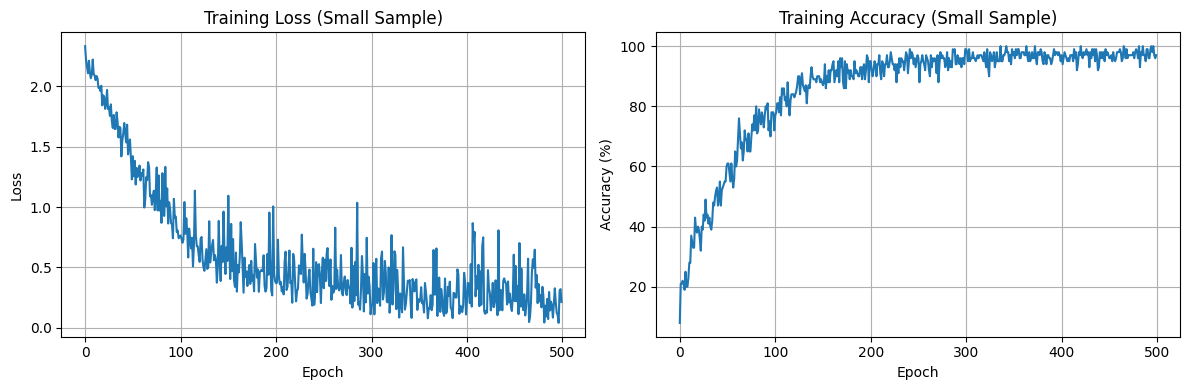


📊 Overfitting Test Results:
   Final Loss: 0.2132
   Final Accuracy: 97.00%
   ⚠️ Model learning but may need more epochs or different hyperparameters


In [12]:
#@title test overfitting
def test_overfitting(model, train_loader_small, test_loader_small, device, epochs=500):
    """Test if model can overfit to a small sample"""
    print("🔍 Testing model's ability to overfit small sample...")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        pbar = tqdm(train_loader_small, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        avg_loss = epoch_loss / len(train_loader_small)
        accuracy = 100. * correct / total
        
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss (Small Sample)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    ax2.plot(train_accs)
    ax2.set_title('Training Accuracy (Small Sample)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    final_loss = train_losses[-1]
    final_acc = train_accs[-1]
    
    print(f"\n📊 Overfitting Test Results:")
    print(f"   Final Loss: {final_loss:.4f}")
    print(f"   Final Accuracy: {final_acc:.2f}%")
    
    if final_loss < 0.1 and final_acc > 95:
        print("   ✅ Model can overfit successfully!")
    elif final_acc > 80:
        print("   ⚠️ Model learning but may need more epochs or different hyperparameters")
    else:
        print("   ❌ Model may have issues - check architecture or hyperparameters")
    
    return final_loss, final_acc

# Run overfitting test
print("\nCreating small sample dataset...")
train_loader_small, test_loader_small = get_small_sample_dataloaders(trainset, testset)

# Test overfitting
model_test = ShuffleNet(groups=3, num_classes=10)
test_loss, test_acc = test_overfitting(model_test, train_loader_small, test_loader_small, device)


In [13]:
#@title training function (updated with checkpoint saving)
def train_shufflenet(model, trainloader, testloader, device, config, filename=None, log_wandb=False):
    """
    Full training function with progress bars, logging, and best model checkpointing.
    
    Args:
        model (nn.Module): The model to train.
        trainloader (DataLoader): DataLoader for the training set.
        testloader (DataLoader): DataLoader for the test set.
        device (str): The device to train on ('cuda' or 'cpu').
        config (dict): A dictionary of training hyperparameters.
        filename (str, optional): Path to save the best model checkpoint. Defaults to None.
        log_wandb (bool, optional): Whether to log metrics to Weights & Biases. Defaults to False.
    """
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=config['learning_rate'], 
                                momentum=config['momentum'], 
                                weight_decay=config['weight_decay'])
    # Using a more robust scheduler like CosineAnnealingLR is often better
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': [],
        'learning_rate': []
    }
    
    # Track the best test accuracy
    best_accuracy = 0.0
    
    print(f"🚀 Starting training for {config['epochs']} epochs...")
    if filename:
        print(f"💾 Best model will be saved to '{filename}'")
    
    # Main training loop
    for epoch in range(config['epochs']):
        # --- Training phase ---
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        train_pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{config["epochs"]} [Train]', leave=False)
        
        for inputs, targets in train_pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%',
                'LR': f'{current_lr:.6f}'
            })
        
        avg_train_loss = train_loss / len(trainloader)
        train_accuracy = 100. * correct / total
        current_lr = optimizer.param_groups[0]['lr']
        
        # --- Validation phase ---
        model.eval()
        test_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
        avg_test_loss = test_loss / len(testloader)
        test_accuracy = 100. * correct / total
        
        # --- Update history and print results ---
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(test_accuracy)
        history['learning_rate'].append(current_lr)
        
        print(f"Epoch {epoch+1:3d}/{config['epochs']:3d} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:6.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:6.2f}% | "
              f"LR: {current_lr:.6f}")

        # <<< START: Checkpoint saving logic >>>
        if filename and test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            print(f"✨ New best accuracy: {best_accuracy:.2f}%. Saving model to {filename}...")
            state = {
                'model_state_dict': model.state_dict(),
                'accuracy': best_accuracy,
                'epoch': epoch + 1,
            }
            torch.save(state, filename)
        # <<< END: Checkpoint saving logic >>>

        if log_wandb:
            wandb.log({
                "epoch": epoch + 1, "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy, "test_loss": avg_test_loss,
                "test_accuracy": test_accuracy, "learning_rate": current_lr
            })
        
        scheduler.step()
        
    print("✅ Training finished.")
    return model, history

In [16]:
#@title Model Evaluation Functions
def evaluate_model_comprehensive(model, testloader, device):
    """Comprehensive model evaluation with all metrics"""
    print("\n" + "="*60)
    print("🔍 COMPREHENSIVE MODEL EVALUATION")
    print("="*60)
    
    # 1. Accuracy Metrics
    print("\n1️⃣ Accuracy Metrics:")
    accuracies = calculate_accuracy(model, testloader, device, top_k=(1, 5))
    print(f"   📊 Top-1 Accuracy: {accuracies[1]:.2f}%")
    print(f"   📊 Top-5 Accuracy: {accuracies[5]:.2f}%")
    
    # 2. Computational Complexity
    print("\n2️⃣ Computational Complexity:")
    model_cpu = model.cpu()  # Move to CPU for FLOP counting
    flops = count_flops(model_cpu)
    model = model.to(device)  # Move back to original device
    print(f"   🧮 FLOPs: {flops:,} ({flops/1e6:.2f} MFLOPs)")
    
    # 3. Inference Performance
    print("\n3️⃣ Inference Performance:")
    avg_latency = measure_inference_time(model, num_runs=100)
    throughput = 1000 / avg_latency
    print(f"   ⚡ Average Inference Time: {avg_latency:.2f} ms")
    print(f"   🚀 Throughput: {throughput:.2f} images/second")
    
    # 4. Model Statistics
    print("\n4️⃣ Model Statistics:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = total_params * 4 / 1024 / 1024
    
    print(f"   📈 Total Parameters: {total_params:,}")
    print(f"   🎯 Trainable Parameters: {trainable_params:,}")
    print(f"   💾 Model Size: {model_size_mb:.2f} MB (float32)")
    
    # 5. Efficiency Metrics
    print("\n5️⃣ Efficiency Metrics:")
    flops_per_param = flops / total_params
    accuracy_per_flop = accuracies[1] / (flops / 1e6)  # Accuracy per MFLOPs
    
    print(f"   ⚖️ FLOPs per Parameter: {flops_per_param:.2f}")
    print(f"   🎯 Accuracy per MFLOP: {accuracy_per_flop:.2f}")
    
    # Create evaluation summary
    eval_results = {
        'top1_accuracy': accuracies[1],
        'top5_accuracy': accuracies[5],
        'flops': flops,
        'flops_mflops': flops / 1e6,
        'inference_time_ms': avg_latency,
        'throughput_imgs_sec': throughput,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'model_size_mb': model_size_mb,
        'flops_per_param': flops_per_param,
        'accuracy_per_mflop': accuracy_per_flop
    }
    
    return eval_results

def plot_training_history(history):
    """Plot training history"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Training and Test Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Training and Test Accuracy', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning rate plot
    ax3.plot(epochs, history['learning_rate'], 'g-', label='Learning Rate', linewidth=2)
    ax3.set_title('Learning Rate Schedule', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Combined accuracy plot
    ax4.plot(epochs, history['train_acc'], 'b-', alpha=0.7, label='Train Accuracy')
    ax4.plot(epochs, history['test_acc'], 'r-', alpha=0.7, label='Test Accuracy')
    ax4.fill_between(epochs, history['train_acc'], alpha=0.3, color='blue')
    ax4.fill_between(epochs, history['test_acc'], alpha=0.3, color='red')
    ax4.set_title('Accuracy Comparison', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def save_model_and_results(model, history, eval_results, filepath='shufflenet_cifar10.pth'):
    """Save model and all results"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_history': history,
        'evaluation_results': eval_results,
        'model_config': {
            'groups': 3,
            'num_classes': 10,
            'architecture': 'ShuffleNet'
        }
    }, filepath)
    print(f"💾 Model and results saved to: {filepath}")

print("✅ Evaluation functions ready!")

✅ Evaluation functions ready!


Running quick training test...
🧪 Running quick training test (5 epochs)...
   Using 1000 training samples and 200 test samples
🚀 Starting training for 5 epochs...


Epoch 1/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   1/  5 | Train Loss: 7.9831 | Train Acc:  10.10% | Test Loss: 2.5698 | Test Acc:   7.50% | LR: 0.010000


Epoch 2/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   2/  5 | Train Loss: 12.2961 | Train Acc:  14.20% | Test Loss: 3.8175 | Test Acc:  10.00% | LR: 0.010000


Epoch 3/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   3/  5 | Train Loss: 6.2614 | Train Acc:  14.00% | Test Loss: 5.4773 | Test Acc:  12.00% | LR: 0.010000


Epoch 4/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   4/  5 | Train Loss: 4.0091 | Train Acc:  19.20% | Test Loss: 2.7678 | Test Acc:  18.50% | LR: 0.005000


Epoch 5/5 [Train]:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5/5 [Test]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch   5/  5 | Train Loss: 2.7840 | Train Acc:  24.20% | Test Loss: 2.2532 | Test Acc:  26.00% | LR: 0.005000

📊 Quick Test Results:
   Final Train Accuracy: 24.20%
   Final Test Accuracy: 26.00%


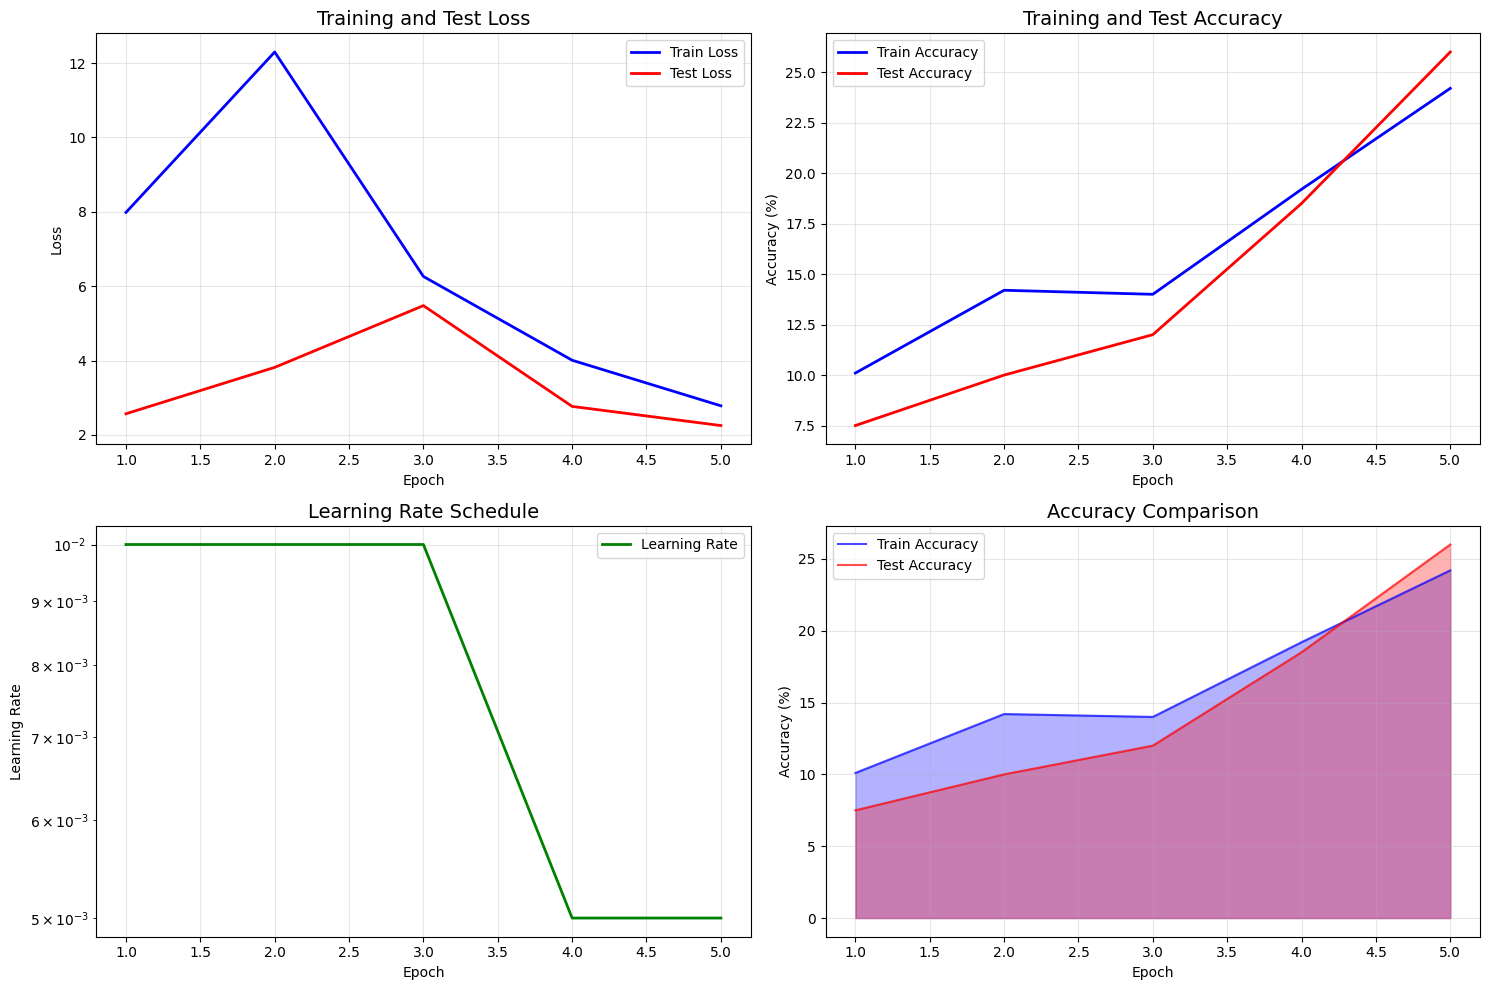

In [17]:
#@title quick test
def quick_training_test(epochs=5):
    """Quick training test with few epochs to verify everything works"""
    print(f"🧪 Running quick training test ({epochs} epochs)...")
    
    # Setup
    model = ShuffleNet(groups=3, num_classes=10)
    
    # Quick config
    quick_config = {
        "epochs": epochs,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "step_size": 3,
        "gamma": 0.5
    }
    
    # Use smaller dataloaders for quick test
    train_subset_indices = torch.randperm(len(trainset))[:1000]  # 1000 samples
    test_subset_indices = torch.randperm(len(testset))[:200]     # 200 samples
    
    train_subset = Subset(trainset, train_subset_indices)
    test_subset = Subset(testset, test_subset_indices)
    
    quick_trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    quick_testloader = DataLoader(test_subset, batch_size=64, shuffle=False)
    
    print(f"   Using {len(train_subset)} training samples and {len(test_subset)} test samples")
    
    # Train
    trained_model, history = train_shufflenet(model, quick_trainloader, quick_testloader, 
                                            device, quick_config, log_wandb=False)
    
    # Quick evaluation
    print(f"\n📊 Quick Test Results:")
    print(f"   Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"   Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    
    # Plot quick results
    plot_training_history(history)
    
    return trained_model, history

# Run quick test
print("Running quick training test...")
quick_model, quick_history = quick_training_test(epochs=5)

✅ Full training pipeline ready!
🚀 Starting Full Training Pipeline...
Configuration:
   architecture: ShuffleNet
   dataset: CIFAR-10
   groups: 3
   batch_size: 128
   learning_rate: 0.1
   momentum: 0.9
   weight_decay: 0.0005
   epochs: 100
   optimizer: SGD
   scheduler: StepLR
   step_size: 50
   gamma: 0.1



⚠️ Wandb logging is disabled. Uncomment lines above to enable.
🎯 Training will take approximately 1-2 hours depending on your hardware.


Continue with full training? (y/n):  y



🏃‍♂️ STARTING FULL TRAINING
🚀 Starting training for 100 epochs...


Epoch 1/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   1/100 | Train Loss: 4.1503 | Train Acc:  27.99% | Test Loss: 1.6577 | Test Acc:  38.75% | LR: 0.100000


Epoch 2/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   2/100 | Train Loss: 1.5961 | Train Acc:  41.25% | Test Loss: 1.4901 | Test Acc:  45.46% | LR: 0.100000


Epoch 3/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   3/100 | Train Loss: 1.4360 | Train Acc:  47.71% | Test Loss: 1.3876 | Test Acc:  51.26% | LR: 0.100000


Epoch 4/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   4/100 | Train Loss: 1.3024 | Train Acc:  52.74% | Test Loss: 1.3476 | Test Acc:  53.08% | LR: 0.100000


Epoch 5/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   5/100 | Train Loss: 1.1722 | Train Acc:  58.22% | Test Loss: 1.1859 | Test Acc:  57.73% | LR: 0.100000


Epoch 6/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   6/100 | Train Loss: 1.0731 | Train Acc:  61.92% | Test Loss: 1.0670 | Test Acc:  61.63% | LR: 0.100000


Epoch 7/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   7/100 | Train Loss: 0.9998 | Train Acc:  64.64% | Test Loss: 1.1007 | Test Acc:  61.70% | LR: 0.100000


Epoch 8/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   8/100 | Train Loss: 0.9122 | Train Acc:  67.80% | Test Loss: 0.9349 | Test Acc:  67.56% | LR: 0.100000


Epoch 9/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch   9/100 | Train Loss: 0.8279 | Train Acc:  71.20% | Test Loss: 0.9311 | Test Acc:  69.37% | LR: 0.100000


Epoch 10/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  10/100 | Train Loss: 0.7689 | Train Acc:  73.16% | Test Loss: 1.2171 | Test Acc:  60.87% | LR: 0.100000


Epoch 11/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  11/100 | Train Loss: 0.7212 | Train Acc:  74.91% | Test Loss: 0.7495 | Test Acc:  74.34% | LR: 0.100000


Epoch 12/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  12/100 | Train Loss: 0.6994 | Train Acc:  75.69% | Test Loss: 0.8010 | Test Acc:  73.29% | LR: 0.100000


Epoch 13/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  13/100 | Train Loss: 0.6735 | Train Acc:  76.64% | Test Loss: 1.2265 | Test Acc:  61.01% | LR: 0.100000


Epoch 14/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  14/100 | Train Loss: 0.6611 | Train Acc:  77.18% | Test Loss: 0.8205 | Test Acc:  72.00% | LR: 0.100000


Epoch 15/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  15/100 | Train Loss: 0.6384 | Train Acc:  78.21% | Test Loss: 0.7003 | Test Acc:  76.21% | LR: 0.100000


Epoch 16/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  16/100 | Train Loss: 0.6290 | Train Acc:  78.07% | Test Loss: 0.6691 | Test Acc:  76.85% | LR: 0.100000


Epoch 17/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  17/100 | Train Loss: 0.6197 | Train Acc:  78.65% | Test Loss: 1.0193 | Test Acc:  68.34% | LR: 0.100000


Epoch 18/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  18/100 | Train Loss: 0.6077 | Train Acc:  79.03% | Test Loss: 0.8011 | Test Acc:  72.78% | LR: 0.100000


Epoch 19/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  19/100 | Train Loss: 0.5967 | Train Acc:  79.40% | Test Loss: 0.8211 | Test Acc:  72.86% | LR: 0.100000


Epoch 20/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  20/100 | Train Loss: 0.5993 | Train Acc:  79.20% | Test Loss: 1.0462 | Test Acc:  67.55% | LR: 0.100000


Epoch 21/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  21/100 | Train Loss: 0.5839 | Train Acc:  79.90% | Test Loss: 0.7731 | Test Acc:  75.10% | LR: 0.100000


Epoch 22/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  22/100 | Train Loss: 0.5811 | Train Acc:  79.85% | Test Loss: 0.7507 | Test Acc:  74.99% | LR: 0.100000


Epoch 23/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  23/100 | Train Loss: 0.5737 | Train Acc:  80.10% | Test Loss: 0.6680 | Test Acc:  77.37% | LR: 0.100000


Epoch 24/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  24/100 | Train Loss: 0.5636 | Train Acc:  80.52% | Test Loss: 0.6832 | Test Acc:  76.74% | LR: 0.100000


Epoch 25/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  25/100 | Train Loss: 0.5591 | Train Acc:  80.57% | Test Loss: 0.8787 | Test Acc:  71.94% | LR: 0.100000


Epoch 26/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  26/100 | Train Loss: 0.5664 | Train Acc:  80.27% | Test Loss: 0.8547 | Test Acc:  72.39% | LR: 0.100000


Epoch 27/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  27/100 | Train Loss: 0.5554 | Train Acc:  80.91% | Test Loss: 0.7673 | Test Acc:  74.84% | LR: 0.100000


Epoch 28/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  28/100 | Train Loss: 0.5478 | Train Acc:  81.15% | Test Loss: 0.7956 | Test Acc:  74.31% | LR: 0.100000


Epoch 29/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  29/100 | Train Loss: 0.5596 | Train Acc:  80.64% | Test Loss: 0.8531 | Test Acc:  73.16% | LR: 0.100000


Epoch 30/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  30/100 | Train Loss: 0.5457 | Train Acc:  81.06% | Test Loss: 0.6132 | Test Acc:  78.86% | LR: 0.100000


Epoch 31/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  31/100 | Train Loss: 0.5452 | Train Acc:  81.09% | Test Loss: 0.7355 | Test Acc:  75.63% | LR: 0.100000


Epoch 32/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  32/100 | Train Loss: 0.5438 | Train Acc:  81.18% | Test Loss: 0.6987 | Test Acc:  76.10% | LR: 0.100000


Epoch 33/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  33/100 | Train Loss: 0.5456 | Train Acc:  81.10% | Test Loss: 0.6430 | Test Acc:  77.84% | LR: 0.100000


Epoch 34/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  34/100 | Train Loss: 0.5360 | Train Acc:  81.56% | Test Loss: 0.6729 | Test Acc:  76.80% | LR: 0.100000


Epoch 35/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  35/100 | Train Loss: 0.5275 | Train Acc:  81.86% | Test Loss: 0.7743 | Test Acc:  74.50% | LR: 0.100000


Epoch 36/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  36/100 | Train Loss: 0.5348 | Train Acc:  81.61% | Test Loss: 0.7485 | Test Acc:  75.48% | LR: 0.100000


Epoch 37/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  37/100 | Train Loss: 0.5276 | Train Acc:  81.63% | Test Loss: 0.7745 | Test Acc:  74.20% | LR: 0.100000


Epoch 38/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  38/100 | Train Loss: 0.5312 | Train Acc:  81.63% | Test Loss: 0.8788 | Test Acc:  72.20% | LR: 0.100000


Epoch 39/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  39/100 | Train Loss: 0.5339 | Train Acc:  81.51% | Test Loss: 0.6404 | Test Acc:  78.32% | LR: 0.100000


Epoch 40/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  40/100 | Train Loss: 0.5254 | Train Acc:  81.86% | Test Loss: 0.6600 | Test Acc:  78.00% | LR: 0.100000


Epoch 41/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  41/100 | Train Loss: 0.5219 | Train Acc:  81.86% | Test Loss: 0.7436 | Test Acc:  75.64% | LR: 0.100000


Epoch 42/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  42/100 | Train Loss: 0.5210 | Train Acc:  82.10% | Test Loss: 0.6668 | Test Acc:  78.03% | LR: 0.100000


Epoch 43/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  43/100 | Train Loss: 0.5261 | Train Acc:  81.79% | Test Loss: 0.7547 | Test Acc:  74.86% | LR: 0.100000


Epoch 44/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  44/100 | Train Loss: 0.5261 | Train Acc:  81.77% | Test Loss: 0.7010 | Test Acc:  76.75% | LR: 0.100000


Epoch 45/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  45/100 | Train Loss: 0.5127 | Train Acc:  82.34% | Test Loss: 0.8291 | Test Acc:  73.90% | LR: 0.100000


Epoch 46/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  46/100 | Train Loss: 0.5233 | Train Acc:  82.15% | Test Loss: 0.7282 | Test Acc:  76.18% | LR: 0.100000


Epoch 47/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  47/100 | Train Loss: 0.5116 | Train Acc:  82.49% | Test Loss: 0.8090 | Test Acc:  73.36% | LR: 0.100000


Epoch 48/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  48/100 | Train Loss: 0.5093 | Train Acc:  82.42% | Test Loss: 0.8676 | Test Acc:  72.35% | LR: 0.100000


Epoch 49/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  49/100 | Train Loss: 0.5110 | Train Acc:  82.44% | Test Loss: 0.8925 | Test Acc:  72.06% | LR: 0.100000


Epoch 50/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  50/100 | Train Loss: 0.5089 | Train Acc:  82.55% | Test Loss: 0.7413 | Test Acc:  76.00% | LR: 0.100000


Epoch 51/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 51/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  51/100 | Train Loss: 0.3530 | Train Acc:  88.05% | Test Loss: 0.3467 | Test Acc:  88.22% | LR: 0.010000


Epoch 52/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 52/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  52/100 | Train Loss: 0.2980 | Train Acc:  89.78% | Test Loss: 0.3236 | Test Acc:  88.56% | LR: 0.010000


Epoch 53/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 53/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  53/100 | Train Loss: 0.2721 | Train Acc:  90.75% | Test Loss: 0.3233 | Test Acc:  88.71% | LR: 0.010000


Epoch 54/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 54/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  54/100 | Train Loss: 0.2581 | Train Acc:  91.02% | Test Loss: 0.3165 | Test Acc:  89.05% | LR: 0.010000


Epoch 55/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 55/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  55/100 | Train Loss: 0.2460 | Train Acc:  91.54% | Test Loss: 0.3198 | Test Acc:  88.92% | LR: 0.010000


Epoch 56/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 56/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  56/100 | Train Loss: 0.2389 | Train Acc:  91.79% | Test Loss: 0.3259 | Test Acc:  88.93% | LR: 0.010000


Epoch 57/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 57/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  57/100 | Train Loss: 0.2277 | Train Acc:  92.24% | Test Loss: 0.3120 | Test Acc:  89.27% | LR: 0.010000


Epoch 58/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 58/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  58/100 | Train Loss: 0.2219 | Train Acc:  92.29% | Test Loss: 0.3122 | Test Acc:  89.38% | LR: 0.010000


Epoch 59/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 59/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  59/100 | Train Loss: 0.2171 | Train Acc:  92.57% | Test Loss: 0.3158 | Test Acc:  89.09% | LR: 0.010000


Epoch 60/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 60/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  60/100 | Train Loss: 0.2069 | Train Acc:  92.76% | Test Loss: 0.3123 | Test Acc:  89.45% | LR: 0.010000


Epoch 61/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 61/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  61/100 | Train Loss: 0.2107 | Train Acc:  92.61% | Test Loss: 0.3395 | Test Acc:  88.77% | LR: 0.010000


Epoch 62/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 62/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  62/100 | Train Loss: 0.2023 | Train Acc:  92.94% | Test Loss: 0.3258 | Test Acc:  88.85% | LR: 0.010000


Epoch 63/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 63/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  63/100 | Train Loss: 0.1986 | Train Acc:  93.06% | Test Loss: 0.3430 | Test Acc:  89.02% | LR: 0.010000


Epoch 64/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 64/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  64/100 | Train Loss: 0.1981 | Train Acc:  93.12% | Test Loss: 0.3279 | Test Acc:  89.19% | LR: 0.010000


Epoch 65/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 65/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  65/100 | Train Loss: 0.1954 | Train Acc:  93.25% | Test Loss: 0.3295 | Test Acc:  89.25% | LR: 0.010000


Epoch 66/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 66/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  66/100 | Train Loss: 0.1909 | Train Acc:  93.31% | Test Loss: 0.3355 | Test Acc:  88.90% | LR: 0.010000


Epoch 67/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 67/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  67/100 | Train Loss: 0.1920 | Train Acc:  93.34% | Test Loss: 0.3421 | Test Acc:  88.89% | LR: 0.010000


Epoch 68/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 68/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  68/100 | Train Loss: 0.1850 | Train Acc:  93.60% | Test Loss: 0.3490 | Test Acc:  88.62% | LR: 0.010000


Epoch 69/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 69/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  69/100 | Train Loss: 0.1859 | Train Acc:  93.35% | Test Loss: 0.3358 | Test Acc:  89.11% | LR: 0.010000


Epoch 70/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 70/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  70/100 | Train Loss: 0.1916 | Train Acc:  93.38% | Test Loss: 0.3333 | Test Acc:  89.10% | LR: 0.010000


Epoch 71/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 71/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  71/100 | Train Loss: 0.1811 | Train Acc:  93.76% | Test Loss: 0.3623 | Test Acc:  88.69% | LR: 0.010000


Epoch 72/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 72/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  72/100 | Train Loss: 0.1829 | Train Acc:  93.71% | Test Loss: 0.3400 | Test Acc:  89.12% | LR: 0.010000


Epoch 73/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 73/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  73/100 | Train Loss: 0.1845 | Train Acc:  93.49% | Test Loss: 0.3658 | Test Acc:  88.25% | LR: 0.010000


Epoch 74/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 74/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  74/100 | Train Loss: 0.1848 | Train Acc:  93.51% | Test Loss: 0.3510 | Test Acc:  89.23% | LR: 0.010000


Epoch 75/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 75/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  75/100 | Train Loss: 0.1797 | Train Acc:  93.76% | Test Loss: 0.3442 | Test Acc:  89.29% | LR: 0.010000


Epoch 76/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 76/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  76/100 | Train Loss: 0.1801 | Train Acc:  93.71% | Test Loss: 0.3555 | Test Acc:  88.77% | LR: 0.010000


Epoch 77/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 77/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  77/100 | Train Loss: 0.1825 | Train Acc:  93.48% | Test Loss: 0.3711 | Test Acc:  88.45% | LR: 0.010000


Epoch 78/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 78/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  78/100 | Train Loss: 0.1769 | Train Acc:  93.78% | Test Loss: 0.3535 | Test Acc:  89.33% | LR: 0.010000


Epoch 79/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 79/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  79/100 | Train Loss: 0.1864 | Train Acc:  93.36% | Test Loss: 0.3683 | Test Acc:  88.83% | LR: 0.010000


Epoch 80/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 80/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  80/100 | Train Loss: 0.1777 | Train Acc:  93.80% | Test Loss: 0.3389 | Test Acc:  89.22% | LR: 0.010000


Epoch 81/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 81/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  81/100 | Train Loss: 0.1821 | Train Acc:  93.44% | Test Loss: 0.3643 | Test Acc:  88.63% | LR: 0.010000


Epoch 82/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 82/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  82/100 | Train Loss: 0.1805 | Train Acc:  93.67% | Test Loss: 0.3568 | Test Acc:  88.91% | LR: 0.010000


Epoch 83/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 83/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  83/100 | Train Loss: 0.1745 | Train Acc:  93.95% | Test Loss: 0.3514 | Test Acc:  89.09% | LR: 0.010000


Epoch 84/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 84/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  84/100 | Train Loss: 0.1781 | Train Acc:  93.74% | Test Loss: 0.3814 | Test Acc:  87.93% | LR: 0.010000


Epoch 85/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 85/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  85/100 | Train Loss: 0.1768 | Train Acc:  93.71% | Test Loss: 0.3515 | Test Acc:  88.88% | LR: 0.010000


Epoch 86/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 86/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  86/100 | Train Loss: 0.1744 | Train Acc:  93.86% | Test Loss: 0.3568 | Test Acc:  88.85% | LR: 0.010000


Epoch 87/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 87/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  87/100 | Train Loss: 0.1758 | Train Acc:  93.82% | Test Loss: 0.3497 | Test Acc:  89.29% | LR: 0.010000


Epoch 88/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 88/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  88/100 | Train Loss: 0.1752 | Train Acc:  93.76% | Test Loss: 0.3529 | Test Acc:  88.77% | LR: 0.010000


Epoch 89/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 89/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  89/100 | Train Loss: 0.1777 | Train Acc:  93.71% | Test Loss: 0.3642 | Test Acc:  88.47% | LR: 0.010000


Epoch 90/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 90/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  90/100 | Train Loss: 0.1763 | Train Acc:  93.74% | Test Loss: 0.4130 | Test Acc:  87.63% | LR: 0.010000


Epoch 91/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 91/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  91/100 | Train Loss: 0.1744 | Train Acc:  93.94% | Test Loss: 0.3381 | Test Acc:  89.48% | LR: 0.010000


Epoch 92/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 92/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  92/100 | Train Loss: 0.1766 | Train Acc:  93.79% | Test Loss: 0.3857 | Test Acc:  87.88% | LR: 0.010000


Epoch 93/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 93/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  93/100 | Train Loss: 0.1726 | Train Acc:  93.94% | Test Loss: 0.3994 | Test Acc:  87.49% | LR: 0.010000


Epoch 94/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 94/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  94/100 | Train Loss: 0.1727 | Train Acc:  93.99% | Test Loss: 0.3768 | Test Acc:  88.22% | LR: 0.010000


Epoch 95/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 95/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  95/100 | Train Loss: 0.1716 | Train Acc:  93.96% | Test Loss: 0.3980 | Test Acc:  87.76% | LR: 0.010000


Epoch 96/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 96/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  96/100 | Train Loss: 0.1699 | Train Acc:  94.07% | Test Loss: 0.3740 | Test Acc:  88.41% | LR: 0.010000


Epoch 97/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 97/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  97/100 | Train Loss: 0.1706 | Train Acc:  94.03% | Test Loss: 0.3896 | Test Acc:  87.75% | LR: 0.010000


Epoch 98/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 98/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  98/100 | Train Loss: 0.1716 | Train Acc:  93.90% | Test Loss: 0.3524 | Test Acc:  88.86% | LR: 0.010000


Epoch 99/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 99/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  99/100 | Train Loss: 0.1710 | Train Acc:  93.94% | Test Loss: 0.3625 | Test Acc:  88.71% | LR: 0.010000


Epoch 100/100 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 100/100 [Test]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: 0.1642 | Train Acc:  94.34% | Test Loss: 0.4386 | Test Acc:  86.60% | LR: 0.010000

🎉 Training completed!

🔍 COMPREHENSIVE MODEL EVALUATION

1️⃣ Accuracy Metrics:


Calculating accuracy:   0%|          | 0/79 [00:00<?, ?it/s]

   📊 Top-1 Accuracy: 86.60%
   📊 Top-5 Accuracy: 99.44%

2️⃣ Computational Complexity:
   🧮 FLOPs: 38,310,144 (38.31 MFLOPs)

3️⃣ Inference Performance:
   ⚡ Average Inference Time: 3.01 ms
   🚀 Throughput: 332.68 images/second

4️⃣ Model Statistics:
   📈 Total Parameters: 862,480
   🎯 Trainable Parameters: 862,480
   💾 Model Size: 3.29 MB (float32)

5️⃣ Efficiency Metrics:
   ⚖️ FLOPs per Parameter: 44.42
   🎯 Accuracy per MFLOP: 2.26


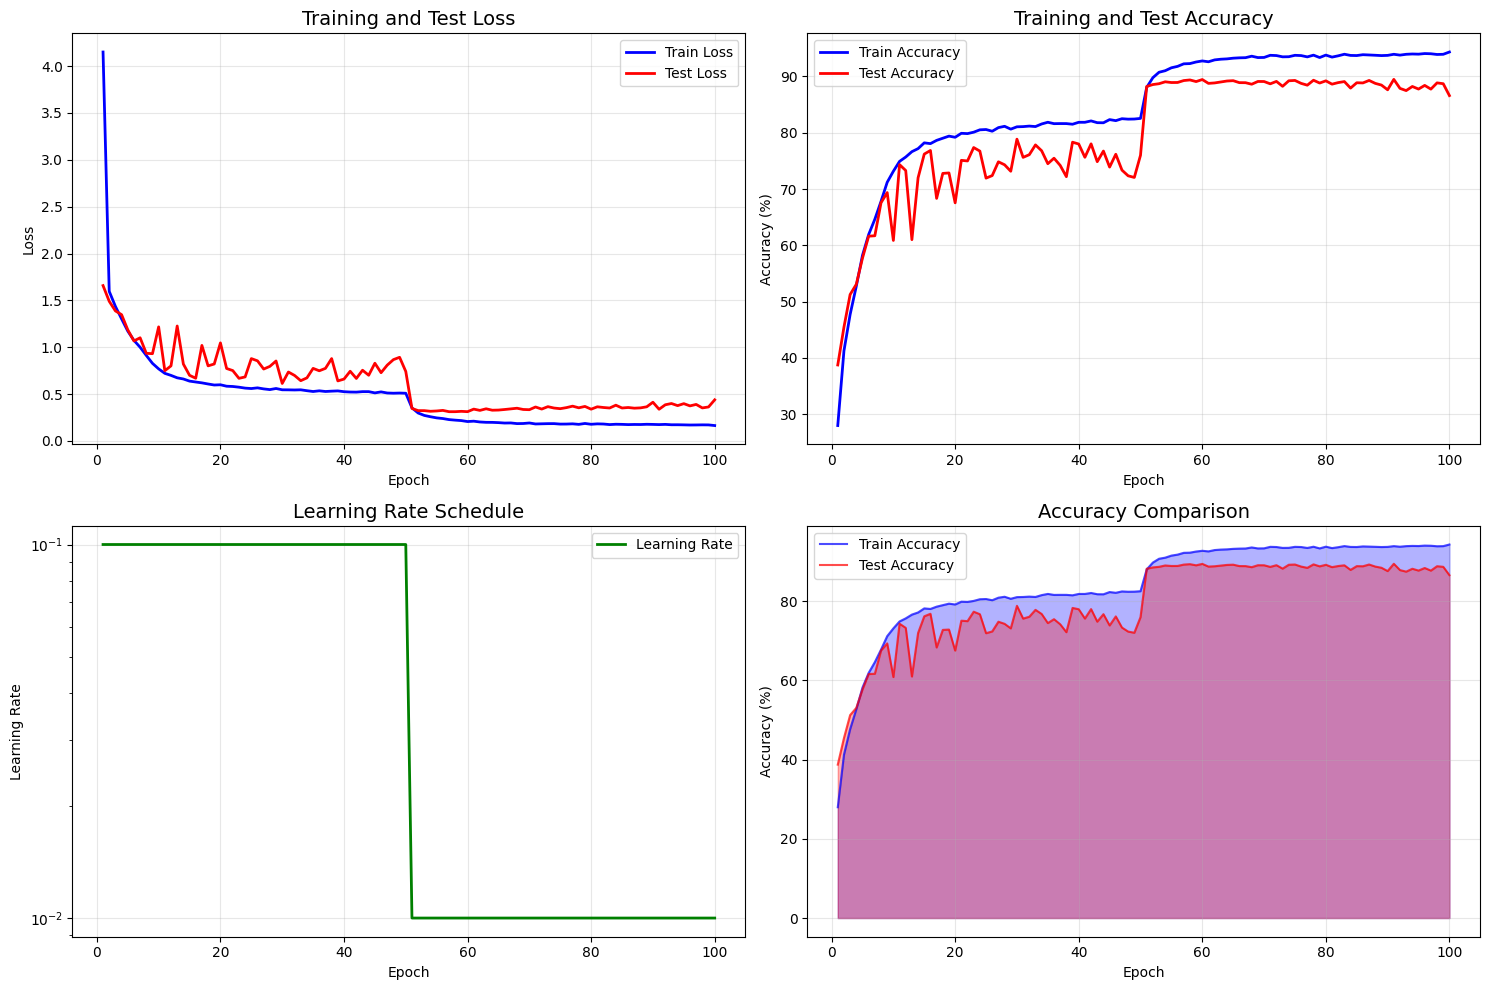

accuracy_per_mflop,▁
flops,▁
flops_mflops,▁
flops_per_param,▁
inference_time_ms,▁
model_size_mb,▁
throughput_imgs_sec,▁
top1_accuracy,▁
top5_accuracy,▁
total_parameters,▁
+1,...


💾 Model and results saved to: shufflenet_cifar10.pth


(ShuffleNet(
   (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (stage2): Sequential(
     (0): ShuffleBlock(
       (conv1): Conv2d(24, 54, kernel_size=(1, 1), stride=(1, 1), groups=3, bias=False)
       (bn1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shuffle): ChannelShuffle()
       (conv2): Conv2d(54, 54, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=54, bias=False)
       (bn2): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(54, 216, kernel_size=(1, 1), stride=(1, 1), groups=3, bias=False)
       (bn3): BatchNorm2d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential(
         (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
       )
       (relu): ReLU(inplace=T

In [18]:
#@title full training
def run_full_training():
    """Run the complete training pipeline"""
    
    print("🚀 Starting Full Training Pipeline...")
    print("="*60)
    
    # Initialize fresh model
    model = ShuffleNet(groups=3, num_classes=10)
    
    # Full training config
    full_config = {
        "architecture": "ShuffleNet",
        "dataset": "CIFAR-10",
        "groups": 3,
        "batch_size": 128,
        "learning_rate": 0.1,
        "momentum": 0.9,
        "weight_decay": 5e-4,
        "epochs": 100,
        "optimizer": "SGD",
        "scheduler": "StepLR",
        "step_size": 50,
        "gamma": 0.1
    }
    
    print("Configuration:")
    for key, value in full_config.items():
        print(f"   {key}: {value}")
    
    # Uncomment the next two lines to enable wandb logging
    wandb.init(project="shufflenet-cifar10", config=full_config, 
              tags=["shufflenet", "cifar10", "full_training"])
    
    print(f"\n⚠️ Wandb logging is disabled. Uncomment lines above to enable.")
    print(f"🎯 Training will take approximately 1-2 hours depending on your hardware.")
    
    # Ask for confirmation
    response = input("Continue with full training? (y/n): ")
    if response.lower() != 'y':
        print("Training cancelled.")
        return None, None, None
    
    # Start training
    print("\n" + "="*60)
    print("🏃‍♂️ STARTING FULL TRAINING")
    print("="*60)
    
    trained_model, history = train_shufflenet(
        model, trainloader, testloader, device, full_config, log_wandb=False
    )
    
    print("\n🎉 Training completed!")
    
    # Comprehensive evaluation
    eval_results = evaluate_model_comprehensive(trained_model, testloader, device)
    
    # Plot training history
    plot_training_history(history)
    
    # Log final results to wandb if enabled
    if wandb.run is not None:
        wandb.log(eval_results)
        wandb.finish()
    
    # Save everything
    save_model_and_results(trained_model, history, eval_results)
    
    return trained_model, history, eval_results

print("✅ Full training pipeline ready!")
run_full_training()

## Thử nghiệm 1:

In [21]:
#@title Cell 4: Exp 1 - Define Architecture without Channel Shuffle
class ShuffleBlockNoShuffle(ShuffleBlock):
    """A modified ShuffleBlock that REMOVES the channel shuffle operation."""
    def forward(self, x):
        shortcut_input = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # --- THE ONLY CHANGE IS HERE: The shuffle line is removed ---
        # out = self.shuffle(out)
        # -----------------------------------------------------------
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.stride == 2:
            shortcut = self.shortcut(shortcut_input)
            out = self.relu(torch.cat([shortcut, out], dim=1))
        else:
            shortcut = shortcut_input
            out = self.relu(out + shortcut)
            
        return out

class ShuffleNetNoShuffle(ShuffleNet):
    """A ShuffleNet that uses the ShuffleBlockNoShuffle variant."""
    def _make_stage(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        # Use the modified block
        layers.append(ShuffleBlockNoShuffle(in_channels, out_channels - in_channels, 
                                            self.groups, stride=stride))
        in_channels = out_channels
        for i in range(num_blocks - 1):
            # Use the modified block
            layers.append(ShuffleBlockNoShuffle(in_channels, in_channels, self.groups, stride=1))
        return nn.Sequential(*layers)

print("✅ 'No Shuffle' architecture defined.")

✅ 'No Shuffle' architecture defined.


In [15]:
#@title Cell 5: Exp 1 - Run Baseline vs. No Shuffle
results_exp1 = {}

# --- 1. Train Baseline Model (with shuffle) ---
print("="*50)
baseline_config = CONFIG.copy()
baseline_config['run_name'] = 'Baseline (g=3, with shuffle)'
baseline_model = ShuffleNet(groups=3).to(DEVICE)
_, baseline_history = train_shufflenet(baseline_model, trainloader, testloader, DEVICE, baseline_config, "shufflenet_experiment_1.pth")
results_exp1['baseline'] = baseline_history

🚀 Starting training for 20 epochs...
💾 Best model will be saved to 'shufflenet_experiment_1.pth'


Epoch 1/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   1/ 20 | Train Loss: 3.8984 | Train Acc:  26.94% | Test Loss: 1.7768 | Test Acc:  34.57% | LR: 0.100000
✨ New best accuracy: 34.57%. Saving model to shufflenet_experiment_1.pth...


Epoch 2/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   2/ 20 | Train Loss: 1.6372 | Train Acc:  39.47% | Test Loss: 1.5956 | Test Acc:  40.56% | LR: 0.099384
✨ New best accuracy: 40.56%. Saving model to shufflenet_experiment_1.pth...


Epoch 3/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   3/ 20 | Train Loss: 1.4797 | Train Acc:  45.73% | Test Loss: 1.3801 | Test Acc:  49.47% | LR: 0.097553
✨ New best accuracy: 49.47%. Saving model to shufflenet_experiment_1.pth...


Epoch 4/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   4/ 20 | Train Loss: 1.3208 | Train Acc:  52.18% | Test Loss: 1.2214 | Test Acc:  56.06% | LR: 0.094550
✨ New best accuracy: 56.06%. Saving model to shufflenet_experiment_1.pth...


Epoch 5/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   5/ 20 | Train Loss: 1.1571 | Train Acc:  58.76% | Test Loss: 1.1583 | Test Acc:  60.04% | LR: 0.090451
✨ New best accuracy: 60.04%. Saving model to shufflenet_experiment_1.pth...


Epoch 6/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   6/ 20 | Train Loss: 1.0483 | Train Acc:  62.85% | Test Loss: 1.0528 | Test Acc:  63.35% | LR: 0.085355
✨ New best accuracy: 63.35%. Saving model to shufflenet_experiment_1.pth...


Epoch 7/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   7/ 20 | Train Loss: 0.9259 | Train Acc:  67.49% | Test Loss: 0.9825 | Test Acc:  69.48% | LR: 0.079389
✨ New best accuracy: 69.48%. Saving model to shufflenet_experiment_1.pth...


Epoch 8/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   8/ 20 | Train Loss: 0.8246 | Train Acc:  71.24% | Test Loss: 0.9872 | Test Acc:  66.50% | LR: 0.072700


Epoch 9/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   9/ 20 | Train Loss: 0.7492 | Train Acc:  74.13% | Test Loss: 0.7539 | Test Acc:  73.67% | LR: 0.065451
✨ New best accuracy: 73.67%. Saving model to shufflenet_experiment_1.pth...


Epoch 10/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  10/ 20 | Train Loss: 0.6960 | Train Acc:  76.02% | Test Loss: 0.7942 | Test Acc:  73.38% | LR: 0.057822


Epoch 11/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  11/ 20 | Train Loss: 0.6484 | Train Acc:  77.50% | Test Loss: 0.7827 | Test Acc:  73.69% | LR: 0.050000
✨ New best accuracy: 73.69%. Saving model to shufflenet_experiment_1.pth...


Epoch 12/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  12/ 20 | Train Loss: 0.5975 | Train Acc:  79.30% | Test Loss: 0.6410 | Test Acc:  77.46% | LR: 0.042178
✨ New best accuracy: 77.46%. Saving model to shufflenet_experiment_1.pth...


Epoch 13/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  13/ 20 | Train Loss: 0.5571 | Train Acc:  80.73% | Test Loss: 0.5871 | Test Acc:  79.70% | LR: 0.034549
✨ New best accuracy: 79.70%. Saving model to shufflenet_experiment_1.pth...


Epoch 14/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  14/ 20 | Train Loss: 0.5064 | Train Acc:  82.40% | Test Loss: 0.6702 | Test Acc:  77.97% | LR: 0.027300


Epoch 15/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  15/ 20 | Train Loss: 0.4627 | Train Acc:  84.04% | Test Loss: 0.5422 | Test Acc:  82.07% | LR: 0.020611
✨ New best accuracy: 82.07%. Saving model to shufflenet_experiment_1.pth...


Epoch 16/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  16/ 20 | Train Loss: 0.4156 | Train Acc:  85.81% | Test Loss: 0.4906 | Test Acc:  83.67% | LR: 0.014645
✨ New best accuracy: 83.67%. Saving model to shufflenet_experiment_1.pth...


Epoch 17/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  17/ 20 | Train Loss: 0.3722 | Train Acc:  87.10% | Test Loss: 0.4449 | Test Acc:  85.06% | LR: 0.009549
✨ New best accuracy: 85.06%. Saving model to shufflenet_experiment_1.pth...


Epoch 18/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  18/ 20 | Train Loss: 0.3337 | Train Acc:  88.53% | Test Loss: 0.4245 | Test Acc:  86.11% | LR: 0.005450
✨ New best accuracy: 86.11%. Saving model to shufflenet_experiment_1.pth...


Epoch 19/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  19/ 20 | Train Loss: 0.2964 | Train Acc:  89.73% | Test Loss: 0.4150 | Test Acc:  86.01% | LR: 0.002447


Epoch 20/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  20/ 20 | Train Loss: 0.2785 | Train Acc:  90.37% | Test Loss: 0.4081 | Test Acc:  86.29% | LR: 0.000616
✨ New best accuracy: 86.29%. Saving model to shufflenet_experiment_1.pth...
✅ Training finished.


In [16]:
# --- 2. Train Model without Shuffle ---
print("\n" + "="*50)
no_shuffle_config = CONFIG.copy()
no_shuffle_config['run_name'] = 'No Shuffle (g=3)'
no_shuffle_model = ShuffleNetNoShuffle(groups=3).to(DEVICE)
_, no_shuffle_history = train_shufflenet(no_shuffle_model, trainloader, testloader, DEVICE, no_shuffle_config, "shufflenet_experiment_1_no_shuffle")
results_exp1['no_shuffle'] = no_shuffle_history


🚀 Starting training for 20 epochs...
💾 Best model will be saved to 'shufflenet_experiment_1_no_shuffle'


Epoch 1/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   1/ 20 | Train Loss: 4.1475 | Train Acc:  22.08% | Test Loss: 1.8568 | Test Acc:  30.26% | LR: 0.100000
✨ New best accuracy: 30.26%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 2/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   2/ 20 | Train Loss: 1.7580 | Train Acc:  33.46% | Test Loss: 1.7292 | Test Acc:  36.82% | LR: 0.099384
✨ New best accuracy: 36.82%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 3/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   3/ 20 | Train Loss: 1.5826 | Train Acc:  41.46% | Test Loss: 1.5356 | Test Acc:  44.74% | LR: 0.097553
✨ New best accuracy: 44.74%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 4/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   4/ 20 | Train Loss: 1.4826 | Train Acc:  45.49% | Test Loss: 1.4652 | Test Acc:  45.59% | LR: 0.094550
✨ New best accuracy: 45.59%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 5/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   5/ 20 | Train Loss: 1.3838 | Train Acc:  49.80% | Test Loss: 1.5886 | Test Acc:  45.44% | LR: 0.090451


Epoch 6/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   6/ 20 | Train Loss: 1.2371 | Train Acc:  55.60% | Test Loss: 1.2584 | Test Acc:  56.17% | LR: 0.085355
✨ New best accuracy: 56.17%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 7/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   7/ 20 | Train Loss: 1.1026 | Train Acc:  60.75% | Test Loss: 1.2664 | Test Acc:  55.67% | LR: 0.079389


Epoch 8/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   8/ 20 | Train Loss: 0.9841 | Train Acc:  65.18% | Test Loss: 1.0110 | Test Acc:  65.00% | LR: 0.072700
✨ New best accuracy: 65.00%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 9/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   9/ 20 | Train Loss: 0.8609 | Train Acc:  69.95% | Test Loss: 0.9626 | Test Acc:  67.31% | LR: 0.065451
✨ New best accuracy: 67.31%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 10/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  10/ 20 | Train Loss: 0.7839 | Train Acc:  72.81% | Test Loss: 0.8179 | Test Acc:  72.07% | LR: 0.057822
✨ New best accuracy: 72.07%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 11/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  11/ 20 | Train Loss: 0.7073 | Train Acc:  75.37% | Test Loss: 0.7458 | Test Acc:  74.88% | LR: 0.050000
✨ New best accuracy: 74.88%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 12/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  12/ 20 | Train Loss: 0.6508 | Train Acc:  77.29% | Test Loss: 0.7496 | Test Acc:  74.70% | LR: 0.042178


Epoch 13/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  13/ 20 | Train Loss: 0.6023 | Train Acc:  79.01% | Test Loss: 0.7050 | Test Acc:  75.84% | LR: 0.034549
✨ New best accuracy: 75.84%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 14/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  14/ 20 | Train Loss: 0.5447 | Train Acc:  81.12% | Test Loss: 0.6717 | Test Acc:  77.47% | LR: 0.027300
✨ New best accuracy: 77.47%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 15/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  15/ 20 | Train Loss: 0.4978 | Train Acc:  82.71% | Test Loss: 0.6579 | Test Acc:  77.80% | LR: 0.020611
✨ New best accuracy: 77.80%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 16/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  16/ 20 | Train Loss: 0.4471 | Train Acc:  84.41% | Test Loss: 0.5012 | Test Acc:  82.89% | LR: 0.014645
✨ New best accuracy: 82.89%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 17/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  17/ 20 | Train Loss: 0.4023 | Train Acc:  86.12% | Test Loss: 0.4732 | Test Acc:  83.91% | LR: 0.009549
✨ New best accuracy: 83.91%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 18/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  18/ 20 | Train Loss: 0.3602 | Train Acc:  87.63% | Test Loss: 0.4269 | Test Acc:  85.60% | LR: 0.005450
✨ New best accuracy: 85.60%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 19/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  19/ 20 | Train Loss: 0.3286 | Train Acc:  88.71% | Test Loss: 0.4090 | Test Acc:  86.16% | LR: 0.002447
✨ New best accuracy: 86.16%. Saving model to shufflenet_experiment_1_no_shuffle...


Epoch 20/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  20/ 20 | Train Loss: 0.3083 | Train Acc:  89.40% | Test Loss: 0.4045 | Test Acc:  86.55% | LR: 0.000616
✨ New best accuracy: 86.55%. Saving model to shufflenet_experiment_1_no_shuffle...
✅ Training finished.


📊 Experiment 1 Results:
  - Final Test Accuracy (Baseline with Shuffle): 86.29%
  - Final Test Accuracy (No Shuffle):          86.55%
  - Accuracy Drop: -0.26%


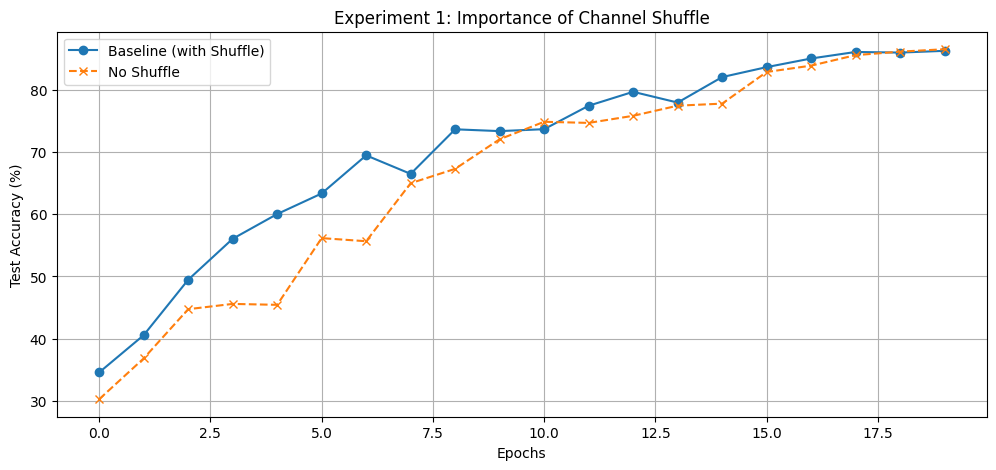

In [17]:
#@title Cell 6: Exp 1 - Compare and Visualize Results
baseline_acc = results_exp1['baseline']['test_acc'][-1]
no_shuffle_acc = results_exp1['no_shuffle']['test_acc'][-1]

print("📊 Experiment 1 Results:")
print(f"  - Final Test Accuracy (Baseline with Shuffle): {baseline_acc:.2f}%")
print(f"  - Final Test Accuracy (No Shuffle):          {no_shuffle_acc:.2f}%")
print(f"  - Accuracy Drop: {(baseline_acc - no_shuffle_acc):.2f}%")

# --- Plotting ---
plt.figure(figsize=(12, 5))
plt.plot(results_exp1['baseline']['test_acc'], label='Baseline (with Shuffle)', marker='o', linestyle='-')
plt.plot(results_exp1['no_shuffle']['test_acc'], label='No Shuffle', marker='x', linestyle='--')
plt.title('Experiment 1: Importance of Channel Shuffle')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## Thử nghiệm 2: Ảnh hưởng của số lượng group

In [35]:
results_exp2 = []

In [36]:
#@title Cell 2: Thử nghiệm với groups = 2
config_g2 = CONFIG.copy()
config_g2['run_name'] = 'ShuffleNet (g=2)'
model_g2 = ShuffleNet(groups=2).to(DEVICE)

_, history_g2 = train_shufflenet(model_g2, trainloader, testloader, DEVICE, config_g2, filename='shufflenet_experiment2_group2.pth')

results_exp2.append({
    'groups': 2,
    'accuracy': history_g2['test_acc'][-1],
    'params_M': count_parameters(model_g2) / 1e6,
    'gflops': count_flops(model_g2) / 1e9
})
print("\n--- Hoàn tất thử nghiệm cho group=2 ---")


--- Hoàn tất thử nghiệm cho group=2 ---


In [37]:
#@title Cell 3: Thử nghiệm với groups = 4
config_g3 = CONFIG.copy()
config_g3['run_name'] = 'ShuffleNet (g=3)'
model_g3 = ShuffleNet(groups=4).to(DEVICE)

_, history_g3 = train_shufflenet(model_g3, trainloader, testloader, DEVICE, config_g3, filename='shufflenet_experiment2_group4.pth')

results_exp2.append({
    'groups': 4,
    'accuracy': history_g3['test_acc'][-1],
    'params_M': count_parameters(model_g3) / 1e6,
    'gflops': count_flops(model_g3) / 1e9
})
print("\n--- Hoàn tất thử nghiệm cho group=4 ---")


--- Hoàn tất thử nghiệm cho group=4 ---


In [38]:
#@title Cell 4: Thử nghiệm với groups = 8
config_g4 = CONFIG.copy()
config_g4['run_name'] = 'ShuffleNet (g=4)'
model_g4 = ShuffleNet(groups=8).to(DEVICE)

_, history_g4 = train_shufflenet(model_g4, trainloader, testloader, DEVICE, config_g4, filename='shufflenet_experiment2_group8.pth')

results_exp2.append({
    'groups': 8,
    'accuracy': history_g4['test_acc'][-1],
    'params_M': count_parameters(model_g4) / 1e6,
    'gflops': count_flops(model_g4) / 1e9
})
print("\n--- Hoàn tất thử nghiệm cho group=8 ---")


--- Hoàn tất thử nghiệm cho group=8 ---


📊 Bảng tổng hợp kết quả Thử nghiệm 2:
   groups accuracy params_M gflops
0       2   86.35%    0.89M  0.040
1       4   87.46%    0.84M  0.037
2       8   88.80%    0.86M  0.038


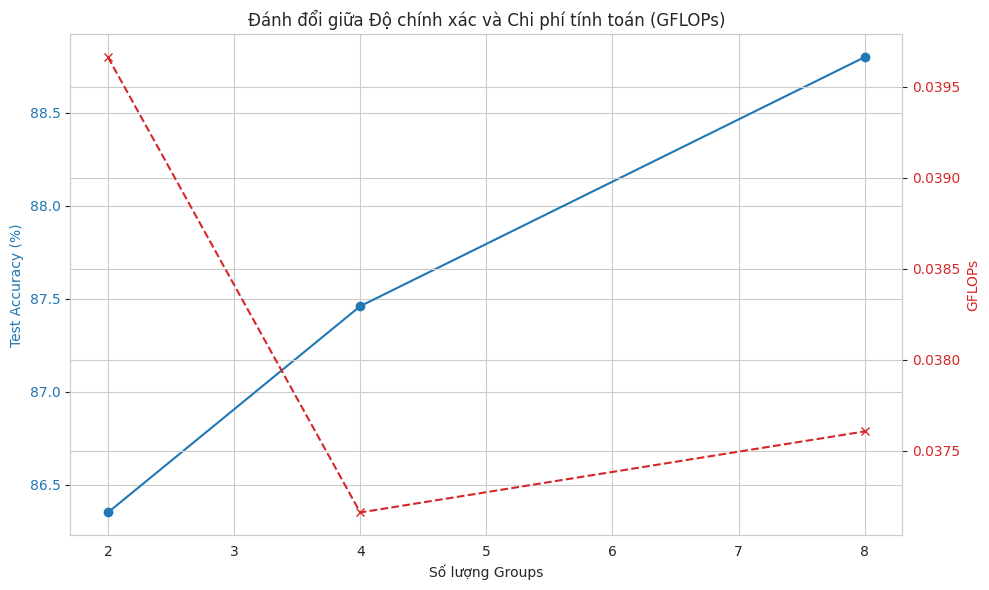

In [39]:
#@title Cell 6: Tổng hợp và Trực quan hóa Kết quả
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tạo DataFrame từ kết quả
df_exp2 = pd.DataFrame(results_exp2).sort_values(by='groups').reset_index(drop=True)

print("📊 Bảng tổng hợp kết quả Thử nghiệm 2:")
print(df_exp2.to_string(formatters={'accuracy':'{:.2f}%'.format, 'params_M':'{:.2f}M'.format, 'gflops':'{:.3f}'.format}))

# Trực quan hóa
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.set_style("whitegrid")

# Accuracy
color = 'tab:blue'
ax1.set_xlabel('Số lượng Groups')
ax1.set_ylabel('Test Accuracy (%)', color=color)
ax1.plot(df_exp2['groups'], df_exp2['accuracy'], color=color, marker='o', label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# GFLOPs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('GFLOPs', color=color)
ax2.plot(df_exp2['groups'], df_exp2['gflops'], color=color, marker='x', linestyle='--', label='GFLOPs')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Đánh đổi giữa Độ chính xác và Chi phí tính toán (GFLOPs)')
fig.tight_layout()
plt.show()

## Thử nghiệm 3: Define Architecture with Less Aggressive Downsampling

In [42]:
#@title Cell 1: Định nghĩa kiến trúc với Hàm Kích Hoạt tùy chỉnh
# Lưu ý: Bạn cần có class ChannelShuffle và ShuffleNet gốc đã được định nghĩa
# và class ShuffleBlock đã được sửa lỗi ở các cell trước.

class ShuffleBlockWithActivation(ShuffleBlock):
    """
    Phiên bản ShuffleBlock cho phép tùy chỉnh hàm kích hoạt.
    """
    def __init__(self, in_channels, out_channels, groups, stride=1, activation_fn=nn.ReLU):
        # Gọi __init__ của class cha (ShuffleBlock đã sửa lỗi)
        super().__init__(in_channels, out_channels, groups, stride)
        
        # THAY ĐỔI: Thay thế ReLU mặc định bằng hàm được cung cấp
        self.relu = activation_fn()

class ShuffleNetWithActivation(ShuffleNet):
    """
    Phiên bản ShuffleNet cho phép tùy chỉnh hàm kích hoạt.
    """
    def __init__(self, groups=3, num_classes=10, activation_fn=nn.ReLU):
        # Lưu lại hàm kích hoạt
        self.activation_fn = activation_fn 
        # Gọi __init__ của class cha
        super().__init__(groups=groups, num_classes=num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        # THAY ĐỔI: Truyền hàm kích hoạt vào khi tạo ShuffleBlock
        layers.append(ShuffleBlockWithActivation(
            in_channels, out_channels - in_channels, self.groups, stride=stride, activation_fn=self.activation_fn
        ))
        
        in_channels = out_channels
        for i in range(num_blocks - 1):
            layers.append(ShuffleBlockWithActivation(
                in_channels, in_channels, self.groups, stride=1, activation_fn=self.activation_fn
            ))
            
        return nn.Sequential(*layers)

print("✅ Kiến trúc với hàm kích hoạt tùy chỉnh đã sẵn sàng.")

✅ Kiến trúc với hàm kích hoạt tùy chỉnh đã sẵn sàng.


In [44]:
#@title Cell 2: Chạy thử nghiệm Baseline (ReLU) và GeLU
results_exp3 = {}

# --- 1. Huấn luyện model Baseline với ReLU ---
# (Bạn có thể sử dụng lại kết quả của model group=3 ở thử nghiệm 2 nếu có)
print("="*50)
config_relu = CONFIG.copy() # Giả sử CONFIG đã được định nghĩa
config_relu['run_name'] = 'ShuffleNet (Activation=ReLU)'
model_relu = ShuffleNetWithActivation(groups=3, activation_fn=nn.ReLU).to(DEVICE)

_, history_relu = train_shufflenet(
    model_relu, trainloader, testloader, DEVICE, config_relu, filename='best_relu.pth'
)
results_exp3['relu'] = history_relu
print("\n--- Hoàn tất huấn luyện với ReLU ---")


# --- 2. Huấn luyện model mới với GELU ---
print("\n" + "="*50)
config_gelu = CONFIG.copy()
config_gelu['run_name'] = 'ShuffleNet (Activation=GELU)'
model_gelu = ShuffleNetWithActivation(groups=3, activation_fn=nn.GELU).to(DEVICE)

_, history_gelu = train_shufflenet(
    model_gelu, trainloader, testloader, DEVICE, config_gelu, filename='best_gelu.pth'
)
results_exp3['gelu'] = history_gelu
print("\n--- Hoàn tất huấn luyện với GELU ---")

🚀 Starting training for 20 epochs...
💾 Best model will be saved to 'best_relu.pth'


Epoch 1/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   1/ 20 | Train Loss: 4.3485 | Train Acc:  22.73% | Test Loss: 1.8701 | Test Acc:  27.97% | LR: 0.100000
✨ New best accuracy: 27.97%. Saving model to best_relu.pth...


Epoch 2/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   2/ 20 | Train Loss: 1.7195 | Train Acc:  33.89% | Test Loss: 1.6527 | Test Acc:  36.53% | LR: 0.099384
✨ New best accuracy: 36.53%. Saving model to best_relu.pth...


Epoch 3/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   3/ 20 | Train Loss: 1.5761 | Train Acc:  40.74% | Test Loss: 1.5197 | Test Acc:  42.70% | LR: 0.097553
✨ New best accuracy: 42.70%. Saving model to best_relu.pth...


Epoch 4/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   4/ 20 | Train Loss: 1.4085 | Train Acc:  48.18% | Test Loss: 1.3004 | Test Acc:  53.13% | LR: 0.094550
✨ New best accuracy: 53.13%. Saving model to best_relu.pth...


Epoch 5/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   5/ 20 | Train Loss: 1.2286 | Train Acc:  55.51% | Test Loss: 1.2809 | Test Acc:  55.18% | LR: 0.090451
✨ New best accuracy: 55.18%. Saving model to best_relu.pth...


Epoch 6/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   6/ 20 | Train Loss: 1.1112 | Train Acc:  60.36% | Test Loss: 1.0710 | Test Acc:  62.22% | LR: 0.085355
✨ New best accuracy: 62.22%. Saving model to best_relu.pth...


Epoch 7/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   7/ 20 | Train Loss: 0.9991 | Train Acc:  64.48% | Test Loss: 1.1687 | Test Acc:  60.74% | LR: 0.079389


Epoch 8/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   8/ 20 | Train Loss: 0.9266 | Train Acc:  67.27% | Test Loss: 0.9953 | Test Acc:  65.22% | LR: 0.072700
✨ New best accuracy: 65.22%. Saving model to best_relu.pth...


Epoch 9/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   9/ 20 | Train Loss: 0.8600 | Train Acc:  69.82% | Test Loss: 1.0127 | Test Acc:  66.11% | LR: 0.065451
✨ New best accuracy: 66.11%. Saving model to best_relu.pth...


Epoch 10/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  10/ 20 | Train Loss: 0.7961 | Train Acc:  71.98% | Test Loss: 0.8115 | Test Acc:  72.00% | LR: 0.057822
✨ New best accuracy: 72.00%. Saving model to best_relu.pth...


Epoch 11/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  11/ 20 | Train Loss: 0.7413 | Train Acc:  74.08% | Test Loss: 0.8768 | Test Acc:  69.82% | LR: 0.050000


Epoch 12/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  12/ 20 | Train Loss: 0.6865 | Train Acc:  76.10% | Test Loss: 0.9109 | Test Acc:  68.33% | LR: 0.042178


Epoch 13/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  13/ 20 | Train Loss: 0.6319 | Train Acc:  77.88% | Test Loss: 0.7559 | Test Acc:  74.82% | LR: 0.034549
✨ New best accuracy: 74.82%. Saving model to best_relu.pth...


Epoch 14/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  14/ 20 | Train Loss: 0.5797 | Train Acc:  79.83% | Test Loss: 0.6166 | Test Acc:  78.91% | LR: 0.027300
✨ New best accuracy: 78.91%. Saving model to best_relu.pth...


Epoch 15/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  15/ 20 | Train Loss: 0.5343 | Train Acc:  81.35% | Test Loss: 0.7347 | Test Acc:  75.59% | LR: 0.020611


Epoch 16/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  16/ 20 | Train Loss: 0.4847 | Train Acc:  83.12% | Test Loss: 0.5844 | Test Acc:  80.09% | LR: 0.014645
✨ New best accuracy: 80.09%. Saving model to best_relu.pth...


Epoch 17/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  17/ 20 | Train Loss: 0.4352 | Train Acc:  84.83% | Test Loss: 0.5522 | Test Acc:  81.40% | LR: 0.009549
✨ New best accuracy: 81.40%. Saving model to best_relu.pth...


Epoch 18/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  18/ 20 | Train Loss: 0.3878 | Train Acc:  86.44% | Test Loss: 0.4889 | Test Acc:  83.92% | LR: 0.005450
✨ New best accuracy: 83.92%. Saving model to best_relu.pth...


Epoch 19/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  19/ 20 | Train Loss: 0.3508 | Train Acc:  87.91% | Test Loss: 0.4656 | Test Acc:  84.31% | LR: 0.002447
✨ New best accuracy: 84.31%. Saving model to best_relu.pth...


Epoch 20/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  20/ 20 | Train Loss: 0.3305 | Train Acc:  88.54% | Test Loss: 0.4568 | Test Acc:  84.68% | LR: 0.000616
✨ New best accuracy: 84.68%. Saving model to best_relu.pth...
✅ Training finished.

--- Hoàn tất huấn luyện với ReLU ---

🚀 Starting training for 20 epochs...
💾 Best model will be saved to 'best_gelu.pth'


Epoch 1/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   1/ 20 | Train Loss: 2.7426 | Train Acc:  29.37% | Test Loss: 1.5460 | Test Acc:  42.38% | LR: 0.100000
✨ New best accuracy: 42.38%. Saving model to best_gelu.pth...


Epoch 2/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   2/ 20 | Train Loss: 1.4720 | Train Acc:  45.88% | Test Loss: 1.3623 | Test Acc:  51.40% | LR: 0.099384
✨ New best accuracy: 51.40%. Saving model to best_gelu.pth...


Epoch 3/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   3/ 20 | Train Loss: 1.2121 | Train Acc:  56.11% | Test Loss: 1.2480 | Test Acc:  57.16% | LR: 0.097553
✨ New best accuracy: 57.16%. Saving model to best_gelu.pth...


Epoch 4/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   4/ 20 | Train Loss: 1.0158 | Train Acc:  63.83% | Test Loss: 1.0351 | Test Acc:  64.98% | LR: 0.094550
✨ New best accuracy: 64.98%. Saving model to best_gelu.pth...


Epoch 5/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   5/ 20 | Train Loss: 0.8837 | Train Acc:  68.74% | Test Loss: 0.8437 | Test Acc:  70.30% | LR: 0.090451
✨ New best accuracy: 70.30%. Saving model to best_gelu.pth...


Epoch 6/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   6/ 20 | Train Loss: 0.7590 | Train Acc:  73.51% | Test Loss: 0.7936 | Test Acc:  72.04% | LR: 0.085355
✨ New best accuracy: 72.04%. Saving model to best_gelu.pth...


Epoch 7/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   7/ 20 | Train Loss: 0.6879 | Train Acc:  75.97% | Test Loss: 0.7140 | Test Acc:  75.71% | LR: 0.079389
✨ New best accuracy: 75.71%. Saving model to best_gelu.pth...


Epoch 8/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   8/ 20 | Train Loss: 0.6370 | Train Acc:  77.87% | Test Loss: 0.7931 | Test Acc:  73.93% | LR: 0.072700


Epoch 9/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch   9/ 20 | Train Loss: 0.5869 | Train Acc:  79.63% | Test Loss: 0.6973 | Test Acc:  76.04% | LR: 0.065451
✨ New best accuracy: 76.04%. Saving model to best_gelu.pth...


Epoch 10/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  10/ 20 | Train Loss: 0.5471 | Train Acc:  80.97% | Test Loss: 0.6300 | Test Acc:  78.16% | LR: 0.057822
✨ New best accuracy: 78.16%. Saving model to best_gelu.pth...


Epoch 11/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  11/ 20 | Train Loss: 0.5111 | Train Acc:  82.41% | Test Loss: 0.5768 | Test Acc:  80.42% | LR: 0.050000
✨ New best accuracy: 80.42%. Saving model to best_gelu.pth...


Epoch 12/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  12/ 20 | Train Loss: 0.4754 | Train Acc:  83.65% | Test Loss: 0.5949 | Test Acc:  79.72% | LR: 0.042178


Epoch 13/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  13/ 20 | Train Loss: 0.4428 | Train Acc:  84.61% | Test Loss: 0.5301 | Test Acc:  81.59% | LR: 0.034549
✨ New best accuracy: 81.59%. Saving model to best_gelu.pth...


Epoch 14/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  14/ 20 | Train Loss: 0.4018 | Train Acc:  85.95% | Test Loss: 0.5055 | Test Acc:  82.58% | LR: 0.027300
✨ New best accuracy: 82.58%. Saving model to best_gelu.pth...


Epoch 15/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  15/ 20 | Train Loss: 0.3622 | Train Acc:  87.37% | Test Loss: 0.4179 | Test Acc:  85.57% | LR: 0.020611
✨ New best accuracy: 85.57%. Saving model to best_gelu.pth...


Epoch 16/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  16/ 20 | Train Loss: 0.3210 | Train Acc:  88.79% | Test Loss: 0.4166 | Test Acc:  86.17% | LR: 0.014645
✨ New best accuracy: 86.17%. Saving model to best_gelu.pth...


Epoch 17/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  17/ 20 | Train Loss: 0.2875 | Train Acc:  89.91% | Test Loss: 0.3748 | Test Acc:  87.25% | LR: 0.009549
✨ New best accuracy: 87.25%. Saving model to best_gelu.pth...


Epoch 18/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  18/ 20 | Train Loss: 0.2504 | Train Acc:  91.32% | Test Loss: 0.3588 | Test Acc:  88.34% | LR: 0.005450
✨ New best accuracy: 88.34%. Saving model to best_gelu.pth...


Epoch 19/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  19/ 20 | Train Loss: 0.2259 | Train Acc:  92.18% | Test Loss: 0.3425 | Test Acc:  88.68% | LR: 0.002447
✨ New best accuracy: 88.68%. Saving model to best_gelu.pth...


Epoch 20/20 [Train]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch  20/ 20 | Train Loss: 0.2113 | Train Acc:  92.76% | Test Loss: 0.3359 | Test Acc:  88.95% | LR: 0.000616
✨ New best accuracy: 88.95%. Saving model to best_gelu.pth...
✅ Training finished.

--- Hoàn tất huấn luyện với GELU ---


📊 Kết quả Thử nghiệm 3 (Hàm Kích Hoạt):
  - Độ chính xác cuối cùng (ReLU): 84.68%
  - Độ chính xác cuối cùng (GELU): 88.95%
  - Chênh lệch: +4.27%


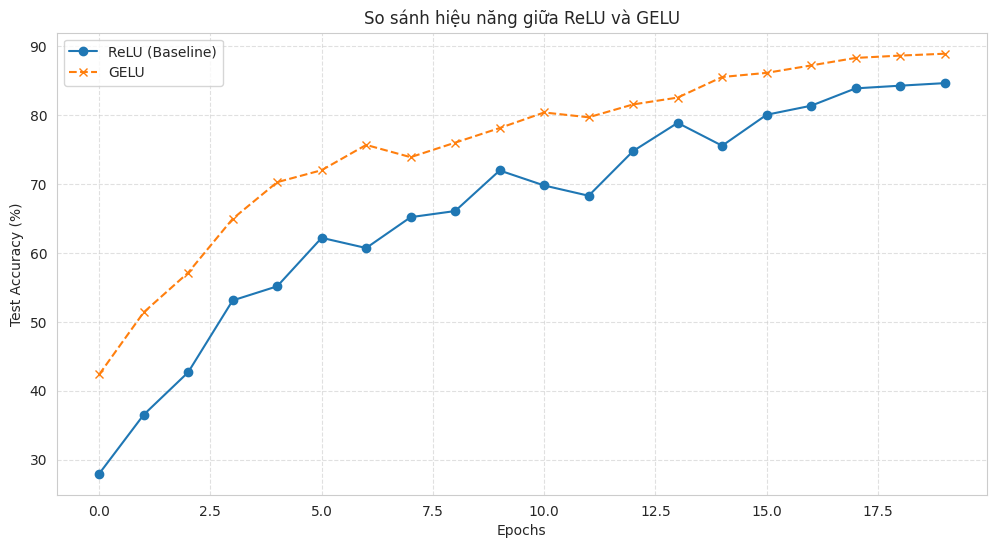

In [45]:
#@title Cell 3: So sánh và Trực quan hóa
import matplotlib.pyplot as plt

# Lấy kết quả accuracy cuối cùng
final_acc_relu = results_exp3['relu']['test_acc'][-1]
final_acc_gelu = results_exp3['gelu']['test_acc'][-1]

print("📊 Kết quả Thử nghiệm 3 (Hàm Kích Hoạt):")
print(f"  - Độ chính xác cuối cùng (ReLU): {final_acc_relu:.2f}%")
print(f"  - Độ chính xác cuối cùng (GELU): {final_acc_gelu:.2f}%")
print(f"  - Chênh lệch: {final_acc_gelu - final_acc_relu:+.2f}%")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(12, 6))
plt.plot(results_exp3['relu']['test_acc'], label='ReLU (Baseline)', marker='o', linestyle='-')
plt.plot(results_exp3['gelu']['test_acc'], label='GELU', marker='x', linestyle='--')

plt.title('So sánh hiệu năng giữa ReLU và GELU')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()